In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn import metrics
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression, Ridge
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import plotly
import chart_studio.plotly as py
import cufflinks as cf

sns.set()
pd.options.plotting.backend = 'plotly'

In [45]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
          corr['x'], corr['y'],
          color=corr['value'], color_range=[-1, 1],
          palette=sns.diverging_palette(20, 220, n=256),
          size=corr['value'].abs(), size_range=[0,1],
          marker=marker,
          x_order=data.columns,
          y_order=data.columns[::-1],
          size_scale=size_scale
      )

In [46]:

def calculos(datos, columna):
    x = datos.drop( columna, axis=1)
    y = datos[columna]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =.2)
    linreg = LinearRegression()
    linreg.fit(x_train, y_train)
    coeff_df = pd.DataFrame(linreg.coef_, x.columns, columns=['Coefficient'])
    
    train_score = linreg.score(x_train,y_train)
    test_score = linreg.score(x_test,y_test)
    predicted = linreg.predict(x_test)
    
    rr = Ridge()
    rr.fit(x_train,y_train)
    rr100 = Ridge(alpha=100)
    rr100.fit(x_train,y_train)
    ridge_train_score = rr.score(x_train,y_train)
    ridge_test_score = rr.score(x_test,y_test)
    predicted_ridge = rr.predict(x_test)
    ridge_train_score100 = rr100.score(x_train,y_train)
    ridge_test_score100 = rr100.score(x_test,y_test)
    predicted_ridge100 = rr100.predict(x_test)
    def grafica1():
        visualizer = ResidualsPlot(linreg, hist=False)
        visualizer.fit(x_test,y_test)
    def grafica2():
        fig = plt.figure(facecolor='w',figsize=(12, 12))
        plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=9,\
             color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7)
        plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=10,\
             color='blue',label=r'Ridge; $\alpha = 200$')
        plt.plot(linreg.coef_,alpha=0.4,linestyle='none',marker='o',markersize=14,\
             color='green',label='Linear Regression')
        plt.xlabel('Coefficient Index',fontsize=16)
        plt.ylabel('Coefficient Magnitude',fontsize=16)
        plt.legend(fontsize=13,loc=4)
        plt.show()
    df_predict = pd.DataFrame({'Actual':y_test, 'Predicted':predicted, 'PredictedRidge':predicted_ridge, 'PredictedRidge100':predicted_ridge100 })
    print (metrics.mean_absolute_error(y_test,predicted), 'Media de error')
    print(train_score, 'Train Score')
    print(test_score, 'Test Score')
    print(ridge_train_score, 'Ridge Train Score')
    print(ridge_test_score, 'Ridge Test Score')
    print(ridge_train_score100, 'Ridge100 Train Score')
    print(ridge_test_score100, 'Ridge100 Test Score')
    
    return grafica1(), grafica2(), print(coeff_df), print(df_predict.head(10))




In [47]:
data = pd.read_csv('./train.csv')

In [48]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [50]:
null_cols = data.isnull().sum()
null_cols[null_cols > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [51]:
data[['PoolQC', 'FireplaceQu','GarageType', 'GarageFinish', 'GarageCond', 'GarageQual','Alley', 'BsmtQual', 'BsmtCond']]=data[['PoolQC', 
                                            'FireplaceQu','GarageType', 'GarageFinish', 'GarageCond', 'GarageQual',
                                           'Alley', 'BsmtQual', 'BsmtCond']].fillna('NA')             

In [52]:
null_cols = data.isnull().sum()
null_cols[null_cols > 10]

LotFrontage      259
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
GarageYrBlt       81
Fence           1179
MiscFeature     1406
dtype: int64

In [53]:
drop_cols = list(null_cols[null_cols > 10].index)
data = data.drop(drop_cols, axis=1)


In [54]:
data = data.dropna(axis=0)

In [55]:
null_cols = data.isnull().sum()
null_cols[null_cols > 0]

Series([], dtype: int64)

In [56]:
data['foundatincat'] = pd.factorize(data.Foundation)[0]
data['bldgtypecat']= pd.factorize(data.BldgType)[0]
data['housestylecat']= pd.factorize(data.HouseStyle)[0]
data['externqualcat']= pd.factorize(data.ExterQual)[0]
data['kitchenquacat']= pd.factorize(data.KitchenQual)[0]
data['gargetypecat']= pd.factorize(data.GarageType)[0]
data['SalePrice']=data.SalePrice.div(100000)

In [57]:
corr = pd.DataFrame(data.corr())
corr['SalePrice'].nlargest(11)

SalePrice       1.000000
OverallQual     0.790085
GrLivArea       0.710073
GarageCars      0.639749
GarageArea      0.622484
TotalBsmtSF     0.613299
1stFlrSF        0.606969
FullBath        0.562710
TotRmsAbvGrd    0.536366
YearBuilt       0.523274
YearRemodAdd    0.507488
Name: SalePrice, dtype: float64

In [58]:
corr['SalePrice'].nsmallest(10)

foundatincat    -0.429450
externqualcat   -0.271452
gargetypecat    -0.255267
housestylecat   -0.188758
KitchenAbvGr    -0.137447
EnclosedPorch   -0.128826
kitchenquacat   -0.119119
bldgtypecat     -0.112324
MSSubClass      -0.082760
OverallCond     -0.076361
Name: SalePrice, dtype: float64

Modelo usando los 5 rubros que tienen mayor correlacion posiiva y los 5 que tiene mayor correlacion negativa

In [59]:
data1= data[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'KitchenAbvGr',
            'EnclosedPorch', 'MSSubClass', 'OverallCond', 'YrSold']]


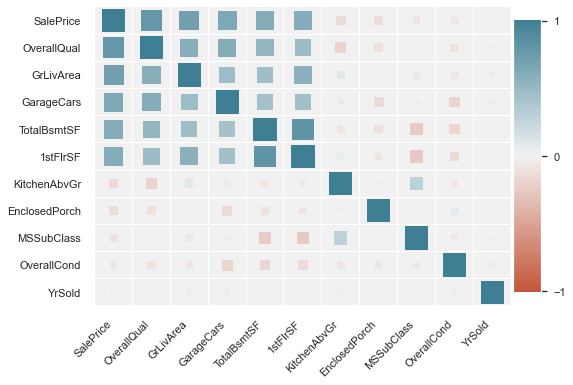

In [60]:
corrplot(data1.corr())

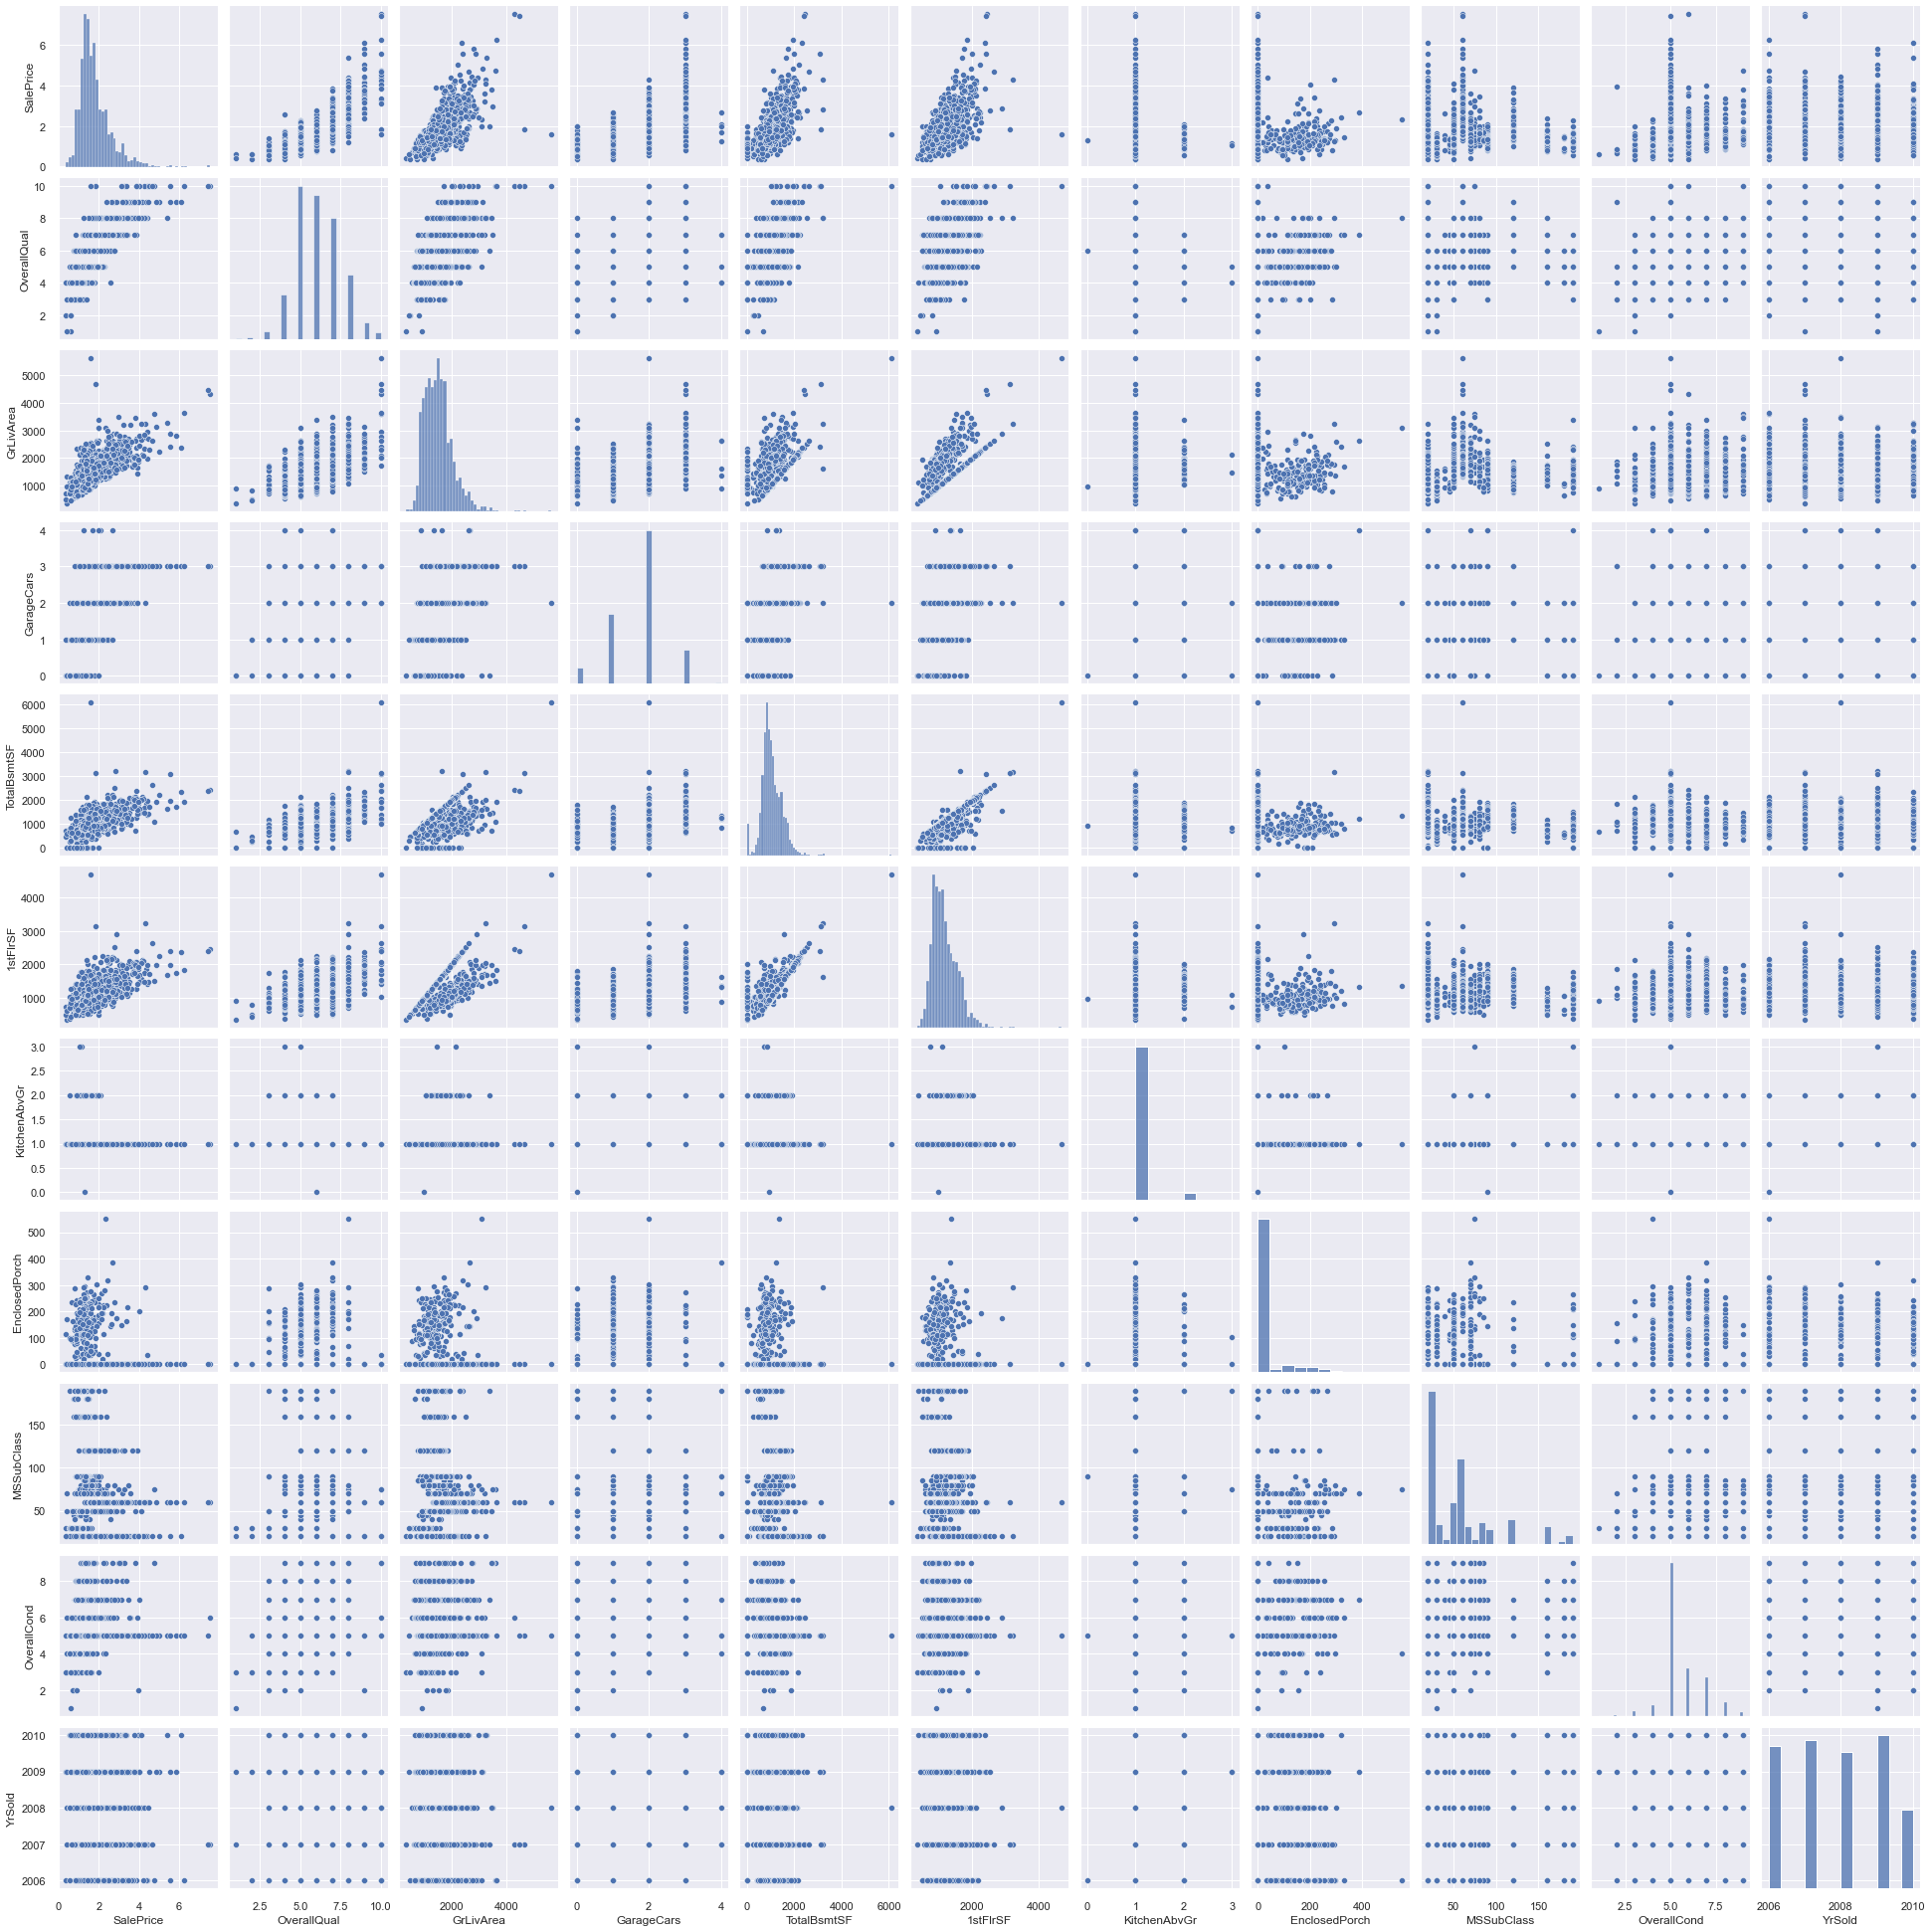

In [61]:
ax= sns.pairplot(data1)

0.22056320488106607 Media de error
0.7716041381978251 Train Score
0.7747033695714318 Test Score
0.7716026869535648 Ridge Train Score
0.7746935183817256 Ridge Test Score
0.769408999899525 Ridge100 Train Score
0.770190837903608 Ridge100 Test Score


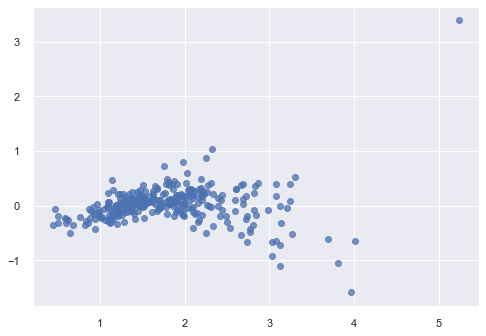

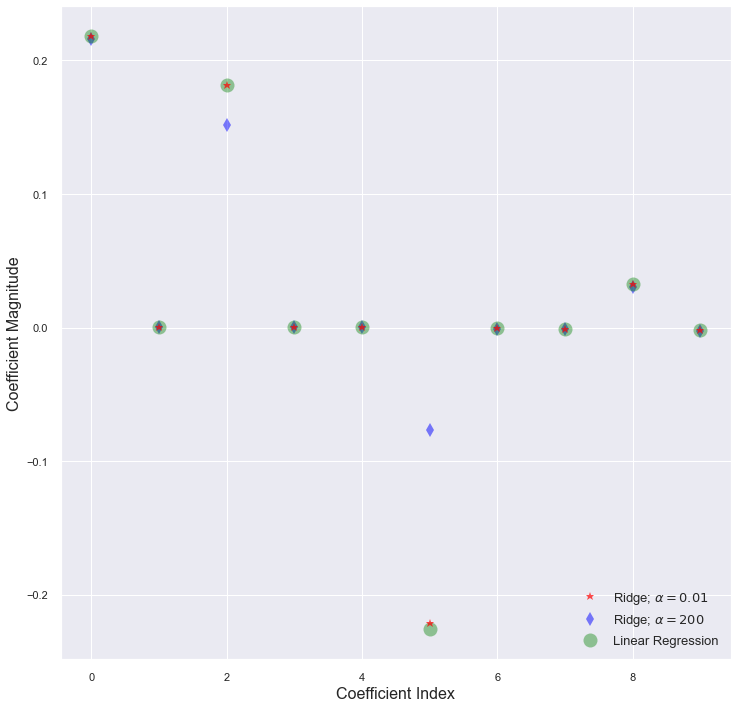

               Coefficient
OverallQual       0.217881
GrLivArea         0.000535
GarageCars        0.181723
TotalBsmtSF       0.000220
1stFlrSF          0.000098
KitchenAbvGr     -0.225765
EnclosedPorch    -0.000702
MSSubClass       -0.000871
OverallCond       0.032374
YrSold           -0.002058
       Actual  Predicted  PredictedRidge  PredictedRidge100
1218  0.80500   0.446197        0.446180           0.467099
426   2.75000   2.252168        2.251678           2.237507
988   1.95000   2.095835        2.095396           2.085116
440   5.55000   3.966629        3.967218           3.982604
1113  1.34500   1.240717        1.241116           1.262361
564   2.68000   2.484315        2.484233           2.487903
471   1.90000   2.276478        2.276178           2.259852
441   1.18000   0.823912        0.828550           1.025160
1241  2.48328   2.588739        2.588454           2.564753
467   1.46500   1.464296        1.464171           1.476980


(None, None, None, None)

In [67]:
calculos(data1,'SalePrice')

Modelo con los 10 rubros con mayor correlacion

In [68]:
data2= data[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF',
            'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']]



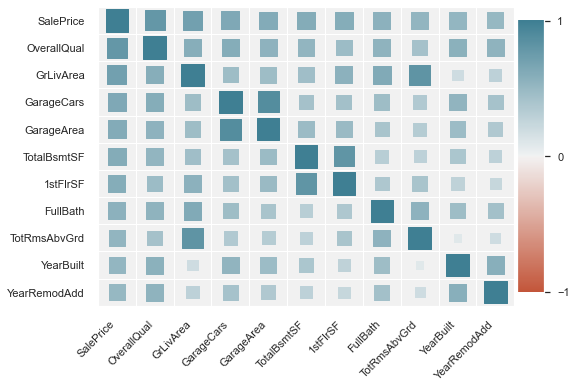

In [69]:
corrplot(data2.corr())

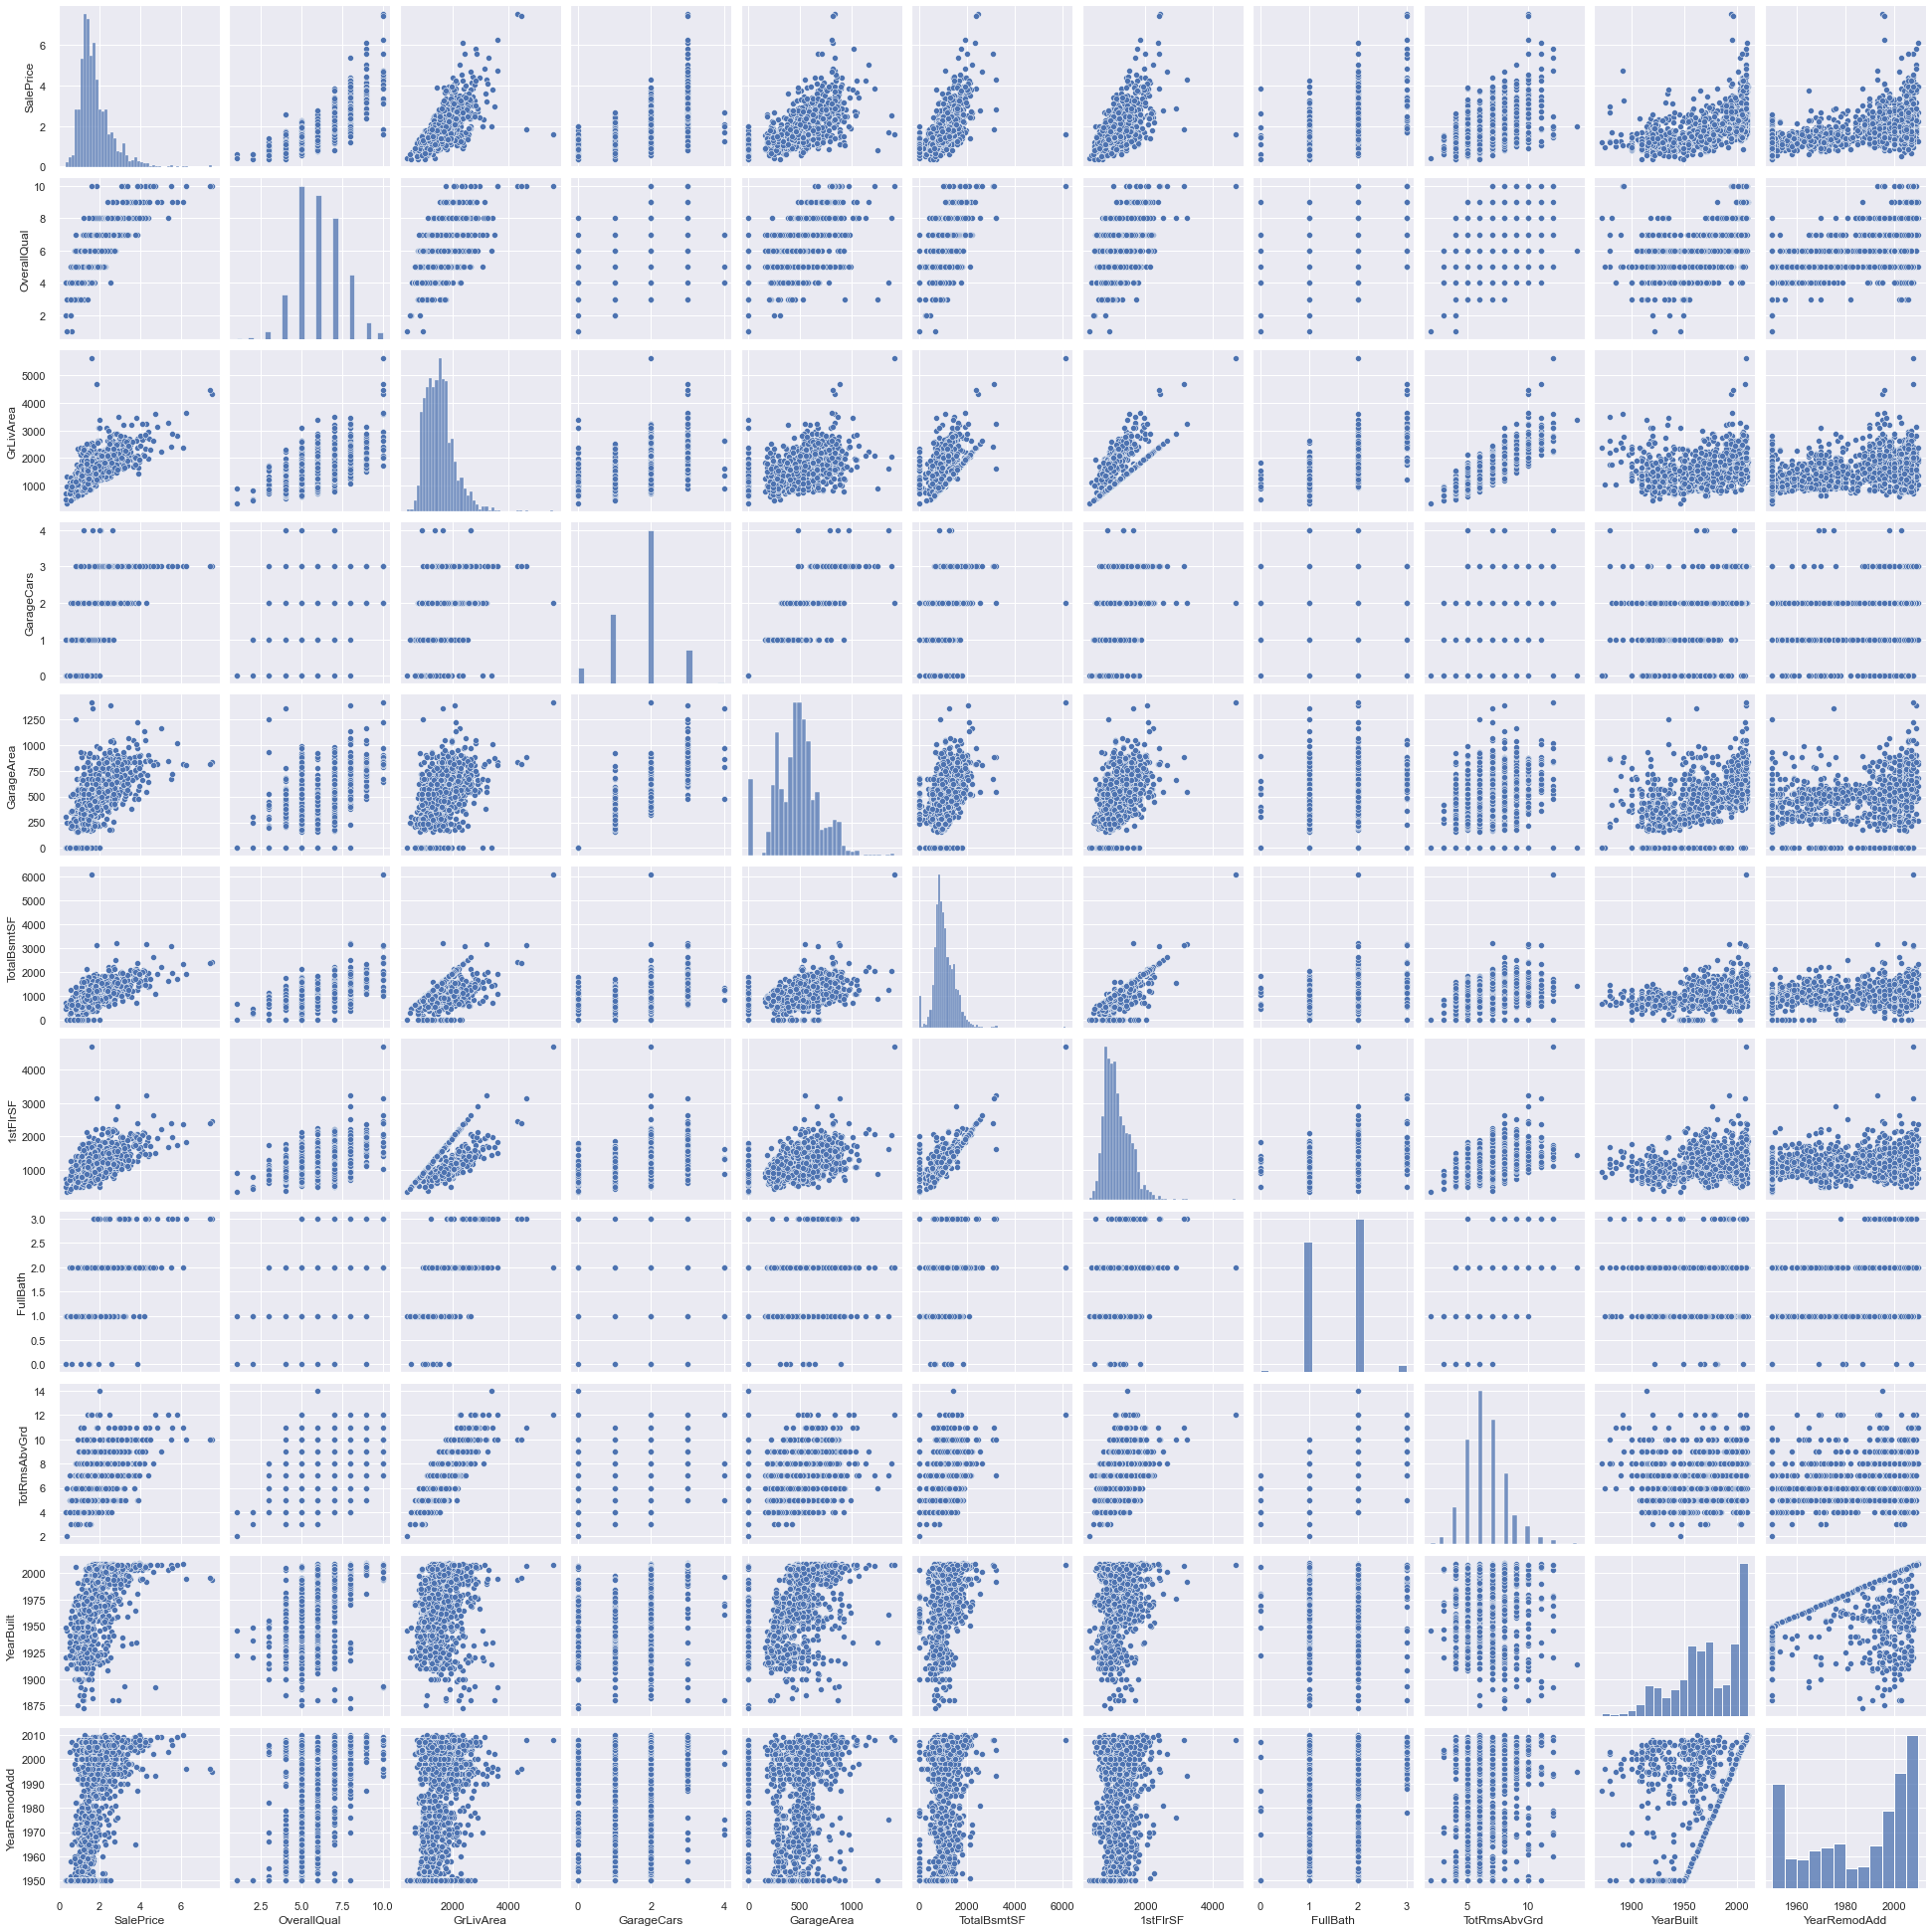

In [70]:
ax= sns.pairplot(data2)

0.23480572789210136 Media de error
0.7711534778914652 Train Score
0.7836634550314926 Test Score
0.7711532421329871 Ridge Train Score
0.7837248263395621 Ridge Test Score
0.7700837107123695 Ridge100 Train Score
0.7868860070276243 Ridge100 Test Score


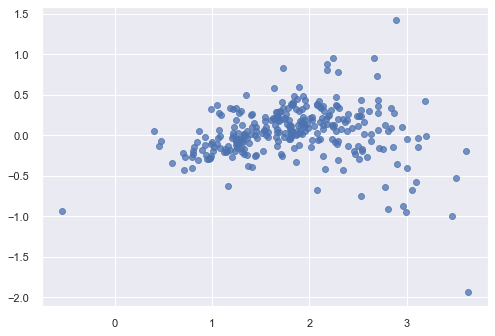

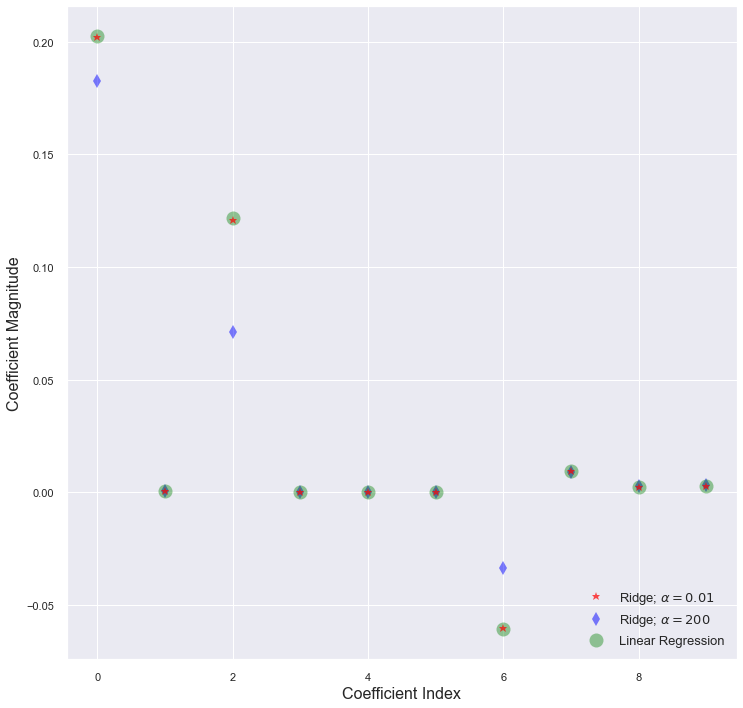

              Coefficient
OverallQual      0.202526
GrLivArea        0.000482
GarageCars       0.121947
GarageArea       0.000084
TotalBsmtSF      0.000177
1stFlrSF         0.000165
FullBath        -0.060661
TotRmsAbvGrd     0.009582
YearBuilt        0.002468
YearRemodAdd     0.002971
       Actual  Predicted  PredictedRidge  PredictedRidge100
1380  0.58500   0.449419        0.449492           0.462936
640   2.74000   2.544817        2.544421           2.513684
1050  1.76485   2.109780        2.109649           2.099962
884   1.00000   1.066263        1.066362           1.071821
1335  1.67900   1.789590        1.790050           1.817199
876   1.32250   1.120342        1.120717           1.153561
887   1.35500   1.255296        1.255368           1.259653
515   4.02861   3.506668        3.506314           3.469724
453   2.10000   2.297167        2.297488           2.307270
191   1.84000   1.976855        1.976263           1.936837


(None, None, None, None)

In [71]:
calculos(data2,'SalePrice')

In [72]:
data.to_excel('train_limpio.xlsx', index=False)

In [73]:
data['timeremodelation'] = data['YearRemodAdd']-data['YearBuilt']

In [131]:
data['antiguedadventa']= data['YrSold']-data['YearBuilt']

In [153]:
condition1= [data['timeremodelation']==0]
choices1= [0]
data['remodelation'] = np.select(condition1,choices1, default= 1)
data['venta']= 1

In [158]:
def survival(data, group_field, time_field, event_field):
    """Documentacion de la funcion."""
    model = KaplanMeierFitter()
    results = []
    con_exp = []
    
    for i in data[group_field].unique():
        group = data[data[group_field] == i]
        T = group[time_field]
        E = group[event_field]
        con_exp.append([T, E])
        model.fit(T, E, label=str(i))
        results.append(model.survival_function_)
    
    survival = pd.concat(results, axis=1)
    front_fill = survival.fillna(method='ffill')
    back_fill = survival.fillna(method='bfill')
    smoothed = (front_fill + back_fill) / 2
    log_result  = logrank_test(con_exp[0][0], con_exp[1][0], 
                               event_observed_A=con_exp[0][1], 
                               event_observed_B=con_exp[1][1])
    return smoothed, log_result

In [159]:
rates, logrank= survival(data, 'Foundation', 'antiguedadventa', 'remodelation')

rates.plot(kind='line',title = 'Indice de remodelacion por antiguedad y materiales de construccion')



Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood

In [160]:
rates, logrank= survival(data, 'BldgType', 'antiguedadventa', 'remodelation')

rates.plot(kind='line',title = 'Indice de remodelacion por antiguedad y tipo de edificio')


BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit

In [163]:
rates, logrank= survival(data, 'OverallQual', 'antiguedadventa', 'venta')

rates.plot(kind='line',title = 'Indice de venta por antiguedad y calidad de la vivienda')


OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

In [165]:
rates, logrank= survival(data, 'GarageCars', 'antiguedadventa', 'venta')
rates.plot(kind='line',title = 'Indice de venta por antiguedad y capicidad del garage')

In [168]:
rates, logrank= survival(data, 'Functional', 'antiguedadventa', 'venta')
rates.plot(kind='line',title = 'Indice de venta por antiguedad y funcionalidad de la vivienda')

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only